In [2]:
root_dir ="/content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/"

In [3]:
!pip install torch-dct --quiet

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import vit_b_16
import torch.optim as optim
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import torch_dct as dct

In [5]:
seed = 43
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
dataset_root_dir = root_dir + 'DeepfakeEmpiricalStudy/dataset/'
temp_dataset_root_dir = root_dir + 'dataset_small/'
train_dir = dataset_root_dir + 'CELEB/train'
val_dir = dataset_root_dir + 'CELEB/val'

models_root_dir = root_dir + 'DeepfakeEmpiricalStudy_Models/'

In [7]:
batch_size = 64
num_epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DCTTransform:
    def __call__(self, tensor):
        # Ensure input is a tensor
        if not isinstance(tensor, torch.Tensor):
            raise TypeError("Input should be a PyTorch tensor")

        # Apply DCT along the width and height (but not the channel dimension)
        # The dct function from torch.fft applies DCT along specified axes
        dct_result = dct.dct(tensor)  # DCT along height and width

        return dct_result


# Define the transform pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image
    transforms.ToTensor(),          # Convert PIL Image to Tensor
    DCTTransform(),                 # Apply the custom DCT transform
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 20)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers= 20)

# class TransformerBasedModel(nn.Module):
#     def __init__(self, num_classes=2):
#         super(TransformerBasedModel, self).__init__()
#         self.vit = vit_b_16(pretrained=True)
#         #self.vit.heads = nn.Linear(self.vit.heads.in_features, num_classes)

#     def forward(self, x):
#         return self.vit(x)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
class TransformerBasedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(TransformerBasedModel, self).__init__()
        self.vit = vit_b_16(pretrained=False)

        vit_weights = torch.load(models_root_dir + 'vit_b_16-c867db91.pth')
        self.vit.load_state_dict(vit_weights)

        for param in self.vit.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(self.vit.heads.head.in_features, num_classes)
        self.vit.heads.head = self.classifier

    def forward(self, x):
        x = self.vit(x)
        return x


model = TransformerBasedModel(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-8-937a6feceaaf>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    best_acc = 0.0
    scaler = torch.cuda.amp.GradScaler()  # Initialize GradScaler for mixed precision

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()  # Scale the loss for backpropagation
            scaler.step(optimizer)  # Update the optimizer
            scaler.update()  # Update the scaler

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, criterion)[0]

        print(f"Epoch {epoch+1}, Loss: {running_loss/total:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), models_root_dir + 'best_trained_model.pth')
            print('Model saved!')

    print(f"Training complete. Best validation accuracy: {best_acc:.4f}")


def evaluate_model(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(inputs)

            # Get predicted classes
            _, predicted = torch.max(outputs, 1)

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and labels
            all_preds.append(predicted)
            all_labels.append(labels)

    # Concatenate all predictions and labels at once
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    return correct / total, all_labels, all_preds


In [10]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

<ipython-input-9-a8dc5aa63a72>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Initialize GradScaler for mixed precision
  0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-9-a8dc5aa63a72>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision
100%|██████████| 250/250 [08:18<00:00,  1.99s/it]
<ipython-input-9-a8dc5aa63a72>:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


Epoch 1, Loss: 0.6885, Train Accuracy: 0.5416, Val Accuracy: 0.5335
Model saved!


100%|██████████| 250/250 [00:36<00:00,  6.91it/s]


Epoch 2, Loss: 0.6823, Train Accuracy: 0.5597, Val Accuracy: 0.5405
Model saved!


100%|██████████| 250/250 [00:36<00:00,  6.85it/s]


Epoch 3, Loss: 0.6781, Train Accuracy: 0.5712, Val Accuracy: 0.5495
Model saved!


100%|██████████| 250/250 [00:36<00:00,  6.81it/s]


Epoch 4, Loss: 0.6748, Train Accuracy: 0.5774, Val Accuracy: 0.5545
Model saved!


100%|██████████| 250/250 [00:36<00:00,  6.82it/s]


Epoch 5, Loss: 0.6725, Train Accuracy: 0.5816, Val Accuracy: 0.5550
Model saved!
Training complete. Best validation accuracy: 0.5550


In [11]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# **Testing**

In [12]:
test_dirs = [dataset_root_dir + 'FS/test', dataset_root_dir + 'NT/test']

In [13]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

<ipython-input-15-8bdb582f195b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(models_root_dir + 'best_trained_model.pth'))
/usr/local/lib

Test Accuracy for /content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/DeepfakeEmpiricalStudy/dataset/FS/test: 0.4680


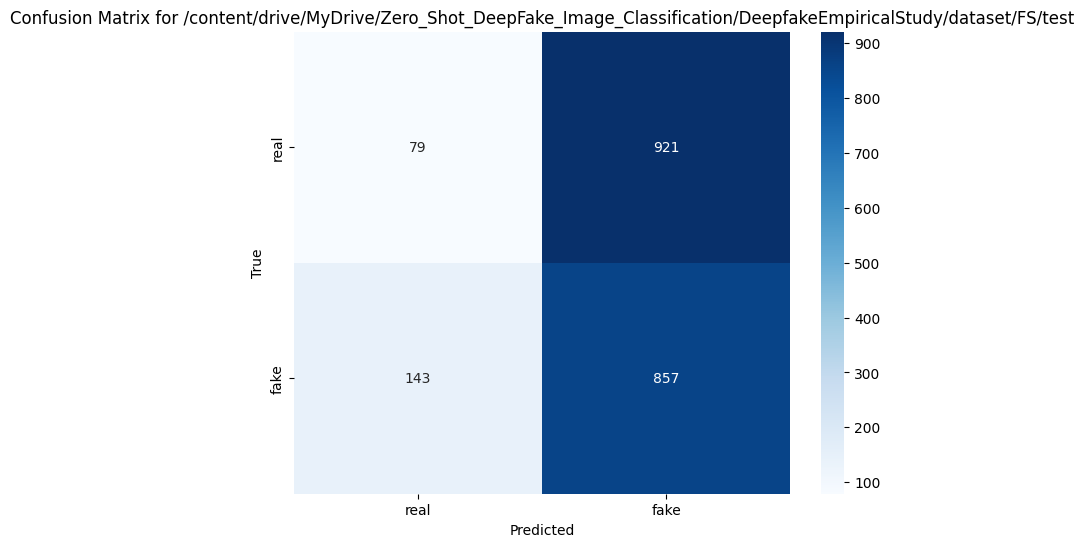

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyboardInterrupt: 

In [15]:
model.load_state_dict(torch.load(models_root_dir + 'best_trained_model.pth'))

all_labels_combined = []
all_preds_combined = []

for test_dir in test_dirs:
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=20)

    test_acc, all_labels, all_preds = evaluate_model(model, test_loader, criterion)
    print(f"Test Accuracy for {test_dir}: {test_acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    plot_confusion_matrix(cm, classes=['real', 'fake'], title=f'Confusion Matrix for {test_dir}')

    all_labels_combined.extend(all_labels)
    all_preds_combined.extend(all_preds)

cm_combined = confusion_matrix(all_labels_combined, all_preds_combined, labels=[0, 1])
print(f"Average Accuracy: {np.mean([evaluate_model(model, DataLoader(datasets.ImageFolder(test_dir, transform=transform), batch_size=batch_size, shuffle=False), criterion)[0] for test_dir in test_dirs]):.4f}")
plot_confusion_matrix(cm_combined, classes=['real', 'fake'], title='Combined Confusion Matrix')

# **Testing on Unseen datasets**

In [19]:
test_dirs = [temp_dataset_root_dir + 'DF/test', temp_dataset_root_dir + 'DFD/test', \
             temp_dataset_root_dir + 'F2F/val' ]

In [20]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [21]:
model.load_state_dict(torch.load(models_root_dir + 'best_trained_model.pth'))

all_labels_combined = []
all_preds_combined = []

for test_dir in test_dirs:
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    test_acc, all_labels, all_preds = evaluate_model(model, test_loader, criterion)
    print(f"Test Accuracy for {test_dir}: {test_acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    plot_confusion_matrix(cm, classes=['real', 'fake'], title=f'Confusion Matrix for {test_dir}')

    all_labels_combined.extend(all_labels)
    all_preds_combined.extend(all_preds)

cm_combined = confusion_matrix(all_labels_combined, all_preds_combined, labels=[0, 1])
print(f"Average Accuracy: {np.mean([evaluate_model(model, DataLoader(datasets.ImageFolder(test_dir, transform=transform), batch_size=batch_size, shuffle=False), criterion)[0] for test_dir in test_dirs]):.4f}")
plot_confusion_matrix(cm_combined, classes=['real', 'fake'], title='Combined Confusion Matrix')

<ipython-input-21-6c41533880cc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(models_root_dir + 'best_trained_model.pth'))


RuntimeError: Error(s) in loading state_dict for TransformerBasedModel:
	Missing key(s) in state_dict: "vit.class_token", "vit.conv_proj.weight", "vit.conv_proj.bias", "vit.encoder.pos_embedding", "vit.encoder.layers.encoder_layer_0.ln_1.weight", "vit.encoder.layers.encoder_layer_0.ln_1.bias", "vit.encoder.layers.encoder_layer_0.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_0.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_0.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_0.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_0.ln_2.weight", "vit.encoder.layers.encoder_layer_0.ln_2.bias", "vit.encoder.layers.encoder_layer_0.mlp.0.weight", "vit.encoder.layers.encoder_layer_0.mlp.0.bias", "vit.encoder.layers.encoder_layer_0.mlp.3.weight", "vit.encoder.layers.encoder_layer_0.mlp.3.bias", "vit.encoder.layers.encoder_layer_1.ln_1.weight", "vit.encoder.layers.encoder_layer_1.ln_1.bias", "vit.encoder.layers.encoder_layer_1.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_1.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_1.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_1.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_1.ln_2.weight", "vit.encoder.layers.encoder_layer_1.ln_2.bias", "vit.encoder.layers.encoder_layer_1.mlp.0.weight", "vit.encoder.layers.encoder_layer_1.mlp.0.bias", "vit.encoder.layers.encoder_layer_1.mlp.3.weight", "vit.encoder.layers.encoder_layer_1.mlp.3.bias", "vit.encoder.layers.encoder_layer_2.ln_1.weight", "vit.encoder.layers.encoder_layer_2.ln_1.bias", "vit.encoder.layers.encoder_layer_2.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_2.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_2.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_2.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_2.ln_2.weight", "vit.encoder.layers.encoder_layer_2.ln_2.bias", "vit.encoder.layers.encoder_layer_2.mlp.0.weight", "vit.encoder.layers.encoder_layer_2.mlp.0.bias", "vit.encoder.layers.encoder_layer_2.mlp.3.weight", "vit.encoder.layers.encoder_layer_2.mlp.3.bias", "vit.encoder.layers.encoder_layer_3.ln_1.weight", "vit.encoder.layers.encoder_layer_3.ln_1.bias", "vit.encoder.layers.encoder_layer_3.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_3.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_3.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_3.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_3.ln_2.weight", "vit.encoder.layers.encoder_layer_3.ln_2.bias", "vit.encoder.layers.encoder_layer_3.mlp.0.weight", "vit.encoder.layers.encoder_layer_3.mlp.0.bias", "vit.encoder.layers.encoder_layer_3.mlp.3.weight", "vit.encoder.layers.encoder_layer_3.mlp.3.bias", "vit.encoder.layers.encoder_layer_4.ln_1.weight", "vit.encoder.layers.encoder_layer_4.ln_1.bias", "vit.encoder.layers.encoder_layer_4.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_4.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_4.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_4.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_4.ln_2.weight", "vit.encoder.layers.encoder_layer_4.ln_2.bias", "vit.encoder.layers.encoder_layer_4.mlp.0.weight", "vit.encoder.layers.encoder_layer_4.mlp.0.bias", "vit.encoder.layers.encoder_layer_4.mlp.3.weight", "vit.encoder.layers.encoder_layer_4.mlp.3.bias", "vit.encoder.layers.encoder_layer_5.ln_1.weight", "vit.encoder.layers.encoder_layer_5.ln_1.bias", "vit.encoder.layers.encoder_layer_5.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_5.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_5.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_5.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_5.ln_2.weight", "vit.encoder.layers.encoder_layer_5.ln_2.bias", "vit.encoder.layers.encoder_layer_5.mlp.0.weight", "vit.encoder.layers.encoder_layer_5.mlp.0.bias", "vit.encoder.layers.encoder_layer_5.mlp.3.weight", "vit.encoder.layers.encoder_layer_5.mlp.3.bias", "vit.encoder.layers.encoder_layer_6.ln_1.weight", "vit.encoder.layers.encoder_layer_6.ln_1.bias", "vit.encoder.layers.encoder_layer_6.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_6.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_6.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_6.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_6.ln_2.weight", "vit.encoder.layers.encoder_layer_6.ln_2.bias", "vit.encoder.layers.encoder_layer_6.mlp.0.weight", "vit.encoder.layers.encoder_layer_6.mlp.0.bias", "vit.encoder.layers.encoder_layer_6.mlp.3.weight", "vit.encoder.layers.encoder_layer_6.mlp.3.bias", "vit.encoder.layers.encoder_layer_7.ln_1.weight", "vit.encoder.layers.encoder_layer_7.ln_1.bias", "vit.encoder.layers.encoder_layer_7.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_7.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_7.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_7.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_7.ln_2.weight", "vit.encoder.layers.encoder_layer_7.ln_2.bias", "vit.encoder.layers.encoder_layer_7.mlp.0.weight", "vit.encoder.layers.encoder_layer_7.mlp.0.bias", "vit.encoder.layers.encoder_layer_7.mlp.3.weight", "vit.encoder.layers.encoder_layer_7.mlp.3.bias", "vit.encoder.layers.encoder_layer_8.ln_1.weight", "vit.encoder.layers.encoder_layer_8.ln_1.bias", "vit.encoder.layers.encoder_layer_8.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_8.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_8.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_8.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_8.ln_2.weight", "vit.encoder.layers.encoder_layer_8.ln_2.bias", "vit.encoder.layers.encoder_layer_8.mlp.0.weight", "vit.encoder.layers.encoder_layer_8.mlp.0.bias", "vit.encoder.layers.encoder_layer_8.mlp.3.weight", "vit.encoder.layers.encoder_layer_8.mlp.3.bias", "vit.encoder.layers.encoder_layer_9.ln_1.weight", "vit.encoder.layers.encoder_layer_9.ln_1.bias", "vit.encoder.layers.encoder_layer_9.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_9.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_9.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_9.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_9.ln_2.weight", "vit.encoder.layers.encoder_layer_9.ln_2.bias", "vit.encoder.layers.encoder_layer_9.mlp.0.weight", "vit.encoder.layers.encoder_layer_9.mlp.0.bias", "vit.encoder.layers.encoder_layer_9.mlp.3.weight", "vit.encoder.layers.encoder_layer_9.mlp.3.bias", "vit.encoder.layers.encoder_layer_10.ln_1.weight", "vit.encoder.layers.encoder_layer_10.ln_1.bias", "vit.encoder.layers.encoder_layer_10.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_10.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_10.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_10.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_10.ln_2.weight", "vit.encoder.layers.encoder_layer_10.ln_2.bias", "vit.encoder.layers.encoder_layer_10.mlp.0.weight", "vit.encoder.layers.encoder_layer_10.mlp.0.bias", "vit.encoder.layers.encoder_layer_10.mlp.3.weight", "vit.encoder.layers.encoder_layer_10.mlp.3.bias", "vit.encoder.layers.encoder_layer_11.ln_1.weight", "vit.encoder.layers.encoder_layer_11.ln_1.bias", "vit.encoder.layers.encoder_layer_11.self_attention.in_proj_weight", "vit.encoder.layers.encoder_layer_11.self_attention.in_proj_bias", "vit.encoder.layers.encoder_layer_11.self_attention.out_proj.weight", "vit.encoder.layers.encoder_layer_11.self_attention.out_proj.bias", "vit.encoder.layers.encoder_layer_11.ln_2.weight", "vit.encoder.layers.encoder_layer_11.ln_2.bias", "vit.encoder.layers.encoder_layer_11.mlp.0.weight", "vit.encoder.layers.encoder_layer_11.mlp.0.bias", "vit.encoder.layers.encoder_layer_11.mlp.3.weight", "vit.encoder.layers.encoder_layer_11.mlp.3.bias", "vit.encoder.ln.weight", "vit.encoder.ln.bias", "vit.heads.head.weight", "vit.heads.head.bias", "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "class_token", "conv_proj.weight", "conv_proj.bias", "encoder.pos_embedding", "encoder.layers.encoder_layer_0.ln_1.weight", "encoder.layers.encoder_layer_0.ln_1.bias", "encoder.layers.encoder_layer_0.self_attention.in_proj_weight", "encoder.layers.encoder_layer_0.self_attention.in_proj_bias", "encoder.layers.encoder_layer_0.self_attention.out_proj.weight", "encoder.layers.encoder_layer_0.self_attention.out_proj.bias", "encoder.layers.encoder_layer_0.ln_2.weight", "encoder.layers.encoder_layer_0.ln_2.bias", "encoder.layers.encoder_layer_0.mlp.linear_1.weight", "encoder.layers.encoder_layer_0.mlp.linear_1.bias", "encoder.layers.encoder_layer_0.mlp.linear_2.weight", "encoder.layers.encoder_layer_0.mlp.linear_2.bias", "encoder.layers.encoder_layer_1.ln_1.weight", "encoder.layers.encoder_layer_1.ln_1.bias", "encoder.layers.encoder_layer_1.self_attention.in_proj_weight", "encoder.layers.encoder_layer_1.self_attention.in_proj_bias", "encoder.layers.encoder_layer_1.self_attention.out_proj.weight", "encoder.layers.encoder_layer_1.self_attention.out_proj.bias", "encoder.layers.encoder_layer_1.ln_2.weight", "encoder.layers.encoder_layer_1.ln_2.bias", "encoder.layers.encoder_layer_1.mlp.linear_1.weight", "encoder.layers.encoder_layer_1.mlp.linear_1.bias", "encoder.layers.encoder_layer_1.mlp.linear_2.weight", "encoder.layers.encoder_layer_1.mlp.linear_2.bias", "encoder.layers.encoder_layer_2.ln_1.weight", "encoder.layers.encoder_layer_2.ln_1.bias", "encoder.layers.encoder_layer_2.self_attention.in_proj_weight", "encoder.layers.encoder_layer_2.self_attention.in_proj_bias", "encoder.layers.encoder_layer_2.self_attention.out_proj.weight", "encoder.layers.encoder_layer_2.self_attention.out_proj.bias", "encoder.layers.encoder_layer_2.ln_2.weight", "encoder.layers.encoder_layer_2.ln_2.bias", "encoder.layers.encoder_layer_2.mlp.linear_1.weight", "encoder.layers.encoder_layer_2.mlp.linear_1.bias", "encoder.layers.encoder_layer_2.mlp.linear_2.weight", "encoder.layers.encoder_layer_2.mlp.linear_2.bias", "encoder.layers.encoder_layer_3.ln_1.weight", "encoder.layers.encoder_layer_3.ln_1.bias", "encoder.layers.encoder_layer_3.self_attention.in_proj_weight", "encoder.layers.encoder_layer_3.self_attention.in_proj_bias", "encoder.layers.encoder_layer_3.self_attention.out_proj.weight", "encoder.layers.encoder_layer_3.self_attention.out_proj.bias", "encoder.layers.encoder_layer_3.ln_2.weight", "encoder.layers.encoder_layer_3.ln_2.bias", "encoder.layers.encoder_layer_3.mlp.linear_1.weight", "encoder.layers.encoder_layer_3.mlp.linear_1.bias", "encoder.layers.encoder_layer_3.mlp.linear_2.weight", "encoder.layers.encoder_layer_3.mlp.linear_2.bias", "encoder.layers.encoder_layer_4.ln_1.weight", "encoder.layers.encoder_layer_4.ln_1.bias", "encoder.layers.encoder_layer_4.self_attention.in_proj_weight", "encoder.layers.encoder_layer_4.self_attention.in_proj_bias", "encoder.layers.encoder_layer_4.self_attention.out_proj.weight", "encoder.layers.encoder_layer_4.self_attention.out_proj.bias", "encoder.layers.encoder_layer_4.ln_2.weight", "encoder.layers.encoder_layer_4.ln_2.bias", "encoder.layers.encoder_layer_4.mlp.linear_1.weight", "encoder.layers.encoder_layer_4.mlp.linear_1.bias", "encoder.layers.encoder_layer_4.mlp.linear_2.weight", "encoder.layers.encoder_layer_4.mlp.linear_2.bias", "encoder.layers.encoder_layer_5.ln_1.weight", "encoder.layers.encoder_layer_5.ln_1.bias", "encoder.layers.encoder_layer_5.self_attention.in_proj_weight", "encoder.layers.encoder_layer_5.self_attention.in_proj_bias", "encoder.layers.encoder_layer_5.self_attention.out_proj.weight", "encoder.layers.encoder_layer_5.self_attention.out_proj.bias", "encoder.layers.encoder_layer_5.ln_2.weight", "encoder.layers.encoder_layer_5.ln_2.bias", "encoder.layers.encoder_layer_5.mlp.linear_1.weight", "encoder.layers.encoder_layer_5.mlp.linear_1.bias", "encoder.layers.encoder_layer_5.mlp.linear_2.weight", "encoder.layers.encoder_layer_5.mlp.linear_2.bias", "encoder.layers.encoder_layer_6.ln_1.weight", "encoder.layers.encoder_layer_6.ln_1.bias", "encoder.layers.encoder_layer_6.self_attention.in_proj_weight", "encoder.layers.encoder_layer_6.self_attention.in_proj_bias", "encoder.layers.encoder_layer_6.self_attention.out_proj.weight", "encoder.layers.encoder_layer_6.self_attention.out_proj.bias", "encoder.layers.encoder_layer_6.ln_2.weight", "encoder.layers.encoder_layer_6.ln_2.bias", "encoder.layers.encoder_layer_6.mlp.linear_1.weight", "encoder.layers.encoder_layer_6.mlp.linear_1.bias", "encoder.layers.encoder_layer_6.mlp.linear_2.weight", "encoder.layers.encoder_layer_6.mlp.linear_2.bias", "encoder.layers.encoder_layer_7.ln_1.weight", "encoder.layers.encoder_layer_7.ln_1.bias", "encoder.layers.encoder_layer_7.self_attention.in_proj_weight", "encoder.layers.encoder_layer_7.self_attention.in_proj_bias", "encoder.layers.encoder_layer_7.self_attention.out_proj.weight", "encoder.layers.encoder_layer_7.self_attention.out_proj.bias", "encoder.layers.encoder_layer_7.ln_2.weight", "encoder.layers.encoder_layer_7.ln_2.bias", "encoder.layers.encoder_layer_7.mlp.linear_1.weight", "encoder.layers.encoder_layer_7.mlp.linear_1.bias", "encoder.layers.encoder_layer_7.mlp.linear_2.weight", "encoder.layers.encoder_layer_7.mlp.linear_2.bias", "encoder.layers.encoder_layer_8.ln_1.weight", "encoder.layers.encoder_layer_8.ln_1.bias", "encoder.layers.encoder_layer_8.self_attention.in_proj_weight", "encoder.layers.encoder_layer_8.self_attention.in_proj_bias", "encoder.layers.encoder_layer_8.self_attention.out_proj.weight", "encoder.layers.encoder_layer_8.self_attention.out_proj.bias", "encoder.layers.encoder_layer_8.ln_2.weight", "encoder.layers.encoder_layer_8.ln_2.bias", "encoder.layers.encoder_layer_8.mlp.linear_1.weight", "encoder.layers.encoder_layer_8.mlp.linear_1.bias", "encoder.layers.encoder_layer_8.mlp.linear_2.weight", "encoder.layers.encoder_layer_8.mlp.linear_2.bias", "encoder.layers.encoder_layer_9.ln_1.weight", "encoder.layers.encoder_layer_9.ln_1.bias", "encoder.layers.encoder_layer_9.self_attention.in_proj_weight", "encoder.layers.encoder_layer_9.self_attention.in_proj_bias", "encoder.layers.encoder_layer_9.self_attention.out_proj.weight", "encoder.layers.encoder_layer_9.self_attention.out_proj.bias", "encoder.layers.encoder_layer_9.ln_2.weight", "encoder.layers.encoder_layer_9.ln_2.bias", "encoder.layers.encoder_layer_9.mlp.linear_1.weight", "encoder.layers.encoder_layer_9.mlp.linear_1.bias", "encoder.layers.encoder_layer_9.mlp.linear_2.weight", "encoder.layers.encoder_layer_9.mlp.linear_2.bias", "encoder.layers.encoder_layer_10.ln_1.weight", "encoder.layers.encoder_layer_10.ln_1.bias", "encoder.layers.encoder_layer_10.self_attention.in_proj_weight", "encoder.layers.encoder_layer_10.self_attention.in_proj_bias", "encoder.layers.encoder_layer_10.self_attention.out_proj.weight", "encoder.layers.encoder_layer_10.self_attention.out_proj.bias", "encoder.layers.encoder_layer_10.ln_2.weight", "encoder.layers.encoder_layer_10.ln_2.bias", "encoder.layers.encoder_layer_10.mlp.linear_1.weight", "encoder.layers.encoder_layer_10.mlp.linear_1.bias", "encoder.layers.encoder_layer_10.mlp.linear_2.weight", "encoder.layers.encoder_layer_10.mlp.linear_2.bias", "encoder.layers.encoder_layer_11.ln_1.weight", "encoder.layers.encoder_layer_11.ln_1.bias", "encoder.layers.encoder_layer_11.self_attention.in_proj_weight", "encoder.layers.encoder_layer_11.self_attention.in_proj_bias", "encoder.layers.encoder_layer_11.self_attention.out_proj.weight", "encoder.layers.encoder_layer_11.self_attention.out_proj.bias", "encoder.layers.encoder_layer_11.ln_2.weight", "encoder.layers.encoder_layer_11.ln_2.bias", "encoder.layers.encoder_layer_11.mlp.linear_1.weight", "encoder.layers.encoder_layer_11.mlp.linear_1.bias", "encoder.layers.encoder_layer_11.mlp.linear_2.weight", "encoder.layers.encoder_layer_11.mlp.linear_2.bias", "encoder.ln.weight", "encoder.ln.bias", "heads.head.weight", "heads.head.bias". 

# **Explainability**

In [9]:
!pip install captum --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.3 MB/s eta 0:00:00


In [10]:
#model.load_state_dict(torch.load(models_root_dir + 'best_trained_model.pth'))

In [16]:
from captum.attr import LayerGradCam, LayerAttribution
import cv2

def visualize_cam_on_image(image, cam_output):
    cam_output = cam_output.cpu().detach().numpy()
    cam_output = (cam_output - cam_output.min()) / (cam_output.max() - cam_output.min())  # Normalize

    cam_output = cv2.resize(cam_output, (image.shape[1], image.shape[2]))  # Reshape to input size
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_output), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap + np.float32(image.permute(1, 2, 0).cpu().detach().numpy())
    cam_image = cam_image / np.max(cam_image)

    return cam_image

def generate_grad_cam(model, input_tensor, target_class=None):
    grad_cam = LayerGradCam(model, model.vit.encoder.layers[-1])
    cam_output = grad_cam.attribute(input_tensor, target=target_class)

    return cam_output

test_dir = temp_dataset_root_dir + 'DF/test'
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Generate Grad-CAM output for a batch of images
model.eval()
inputs, _ = next(iter(test_loader))  # Get a batch of validation images
inputs = inputs.to(device)

cam_output = generate_grad_cam(model, inputs, target_class = 0)

# **visualize_cam_on_image**

In [ ]:
for i in range(inputs.size(0)):
    print(inputs[i].shape)
    cam_image = visualize_cam_on_image(inputs[i], cam_output[i])
    plt.imshow(cam_image)
    plt.title(f"Image {i+1}")
    plt.show()

# **Clustering Heatmap Features**

In [17]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def flatten_heatmap(cam_output):
    cam_output = cam_output.cpu().detach().numpy().flatten()
    return cam_output

# Generate a batch of flattened heatmaps
flattened_heatmaps = np.array([flatten_heatmap(cam_output[i]) for i in range(batch_size)])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(flattened_heatmaps)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(reduced_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2)

# **Visualize Clusters**

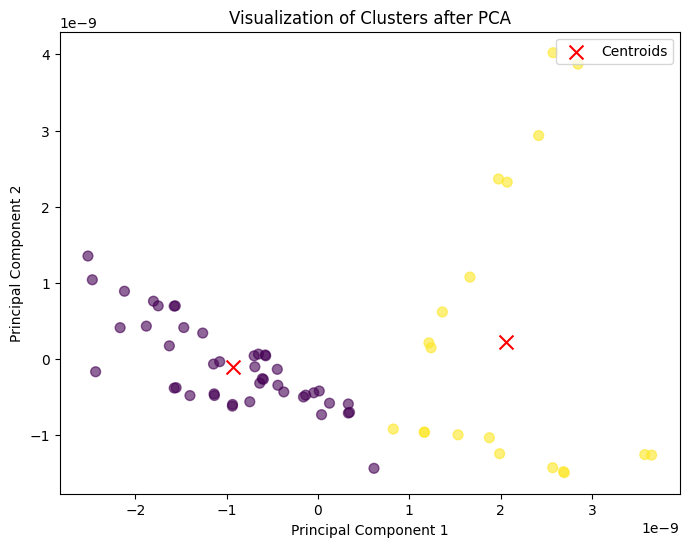

In [18]:
import matplotlib.pyplot as plt

# Assuming you have already performed PCA and KMeans clustering
# reduced_data contains the 2D PCA-reduced data
# kmeans.labels_ contains the cluster labels from KMeans

# Scatter plot of the clusters
plt.figure(figsize=(8, 6))

# Plot each cluster in a different color
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.6)

# Optionally, you can plot the cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='x', label='Centroids')

# Labeling the plot
plt.title('Visualization of Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()

# **Evaluate Cluster Separation**

In [15]:
from sklearn.metrics import silhouette_score

# Compute Silhouette Score (ranges from -1 to 1, where 1 indicates well-separated clusters)
silhouette_avg = silhouette_score(reduced_data, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

# Inertia (sum of squared distances to closest cluster center)
print(f'KMeans Inertia: {kmeans.inertia_}')

Silhouette Score: 0.5142995119094849
KMeans Inertia: 1.034543674812639e-16


# **Label Mapping**

In [ ]:
# Assuming labels are known for each heatmap
true_labels = np.array([0 if label == 'real' else 1 for label in image_labels])  # Assuming binary labels (0 for real, 1 for fake)

# Compare cluster labels with true labels
cluster_labels = kmeans.labels_

# Compute accuracy or confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(true_labels, cluster_labels)
print(f'Clustering Accuracy: {accuracy}')

cm = confusion_matrix(true_labels, cluster_labels)
print('Confusion Matrix:')
print(cm)